# Generate figures based on the data from Stylus scores

In [1]:
import os
import re
import sys
import xmltodict

import matplotlib.pyplot as plt
import numpy as np

from itertools import permutations
from PIL import Image, ImageDraw
from random import randint, seed

from xmlparse import xmlToGeometry, loadRef, loadGeometry, loadGeometryFNames
from score_strokes import alignStrokes, alignStrokesResolve

import numpy as np

In [2]:
han_char = "5EA6"
ref_g, ref_l, output_size = loadRef(han_char, "Reference")
g, l = loadGeometry("HanBitmap", han_char, output_size, f_read = ["54"])[0]
print(len(ref_g), len(g))

9 9


In [3]:
alignments = np.array(alignStrokes(g, ref_g, l, ref_l), dtype=int)

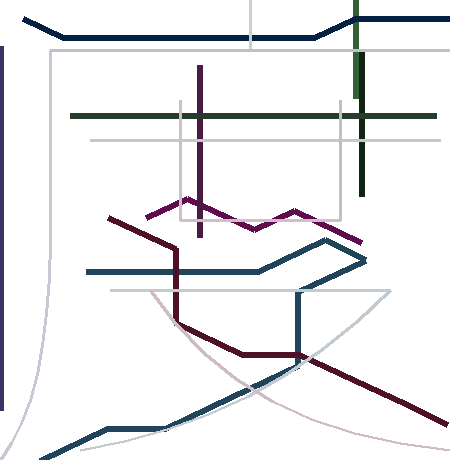

In [4]:
img = Image.new(mode="RGBA", size=output_size)
seed(ref_l[0][0])
colors = [(randint(0, 100), randint(0, 100), randint(0, 100)) for _ in range(len(ref_l)+1)]
colors_t = [(c[0], c[1], c[2], 70) for c in colors]

for i, r in enumerate(alignments):
    draw = ImageDraw.Draw(img)
    for a in range(len(g[i])-1):
        x1, y1 = g[i][a]
        x2, y2 = g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[r])

for i, c in enumerate(colors_t[:-1]):
    draw = ImageDraw.Draw(img)
    for a in range(len(ref_g[i])-1):
        x1, y1 = ref_g[i][a]
        x2, y2 = ref_g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=3, fill=c)
display(img)
img.save(f"{han_char}_matching.png")

In [5]:
perms = np.array([i for i in permutations(range(1, 10))]) # generate permutation map so we can reference which stroke alignment corrisponds to the max exhaustive scores

# 400_exhaust.npy in model mapping
exhaustive_scores = np.load("Exhaustive/exhaust_5EA6_5EA6_Genes_testing set_maint_0.2 on 5EA6.01_5EA6.01.38.gene.npy")
max_exhaustive = np.max(exhaustive_scores)
max_exhaustive_perm = perms[np.argmax(exhaustive_scores)]

alignment_ind = np.argmax(np.array([(perms[i] == alignments+1).all() for i in range(len(perms))]))

alignment_ind == np.argmax(exhaustive_scores) # check if the score for alignment is the same as the one for exhastive max

True

In [6]:
def sortExhaustiveScores(ref_char, han_char, f_read, exhaust_dir = "Exhaustive", conflict_resolution = False):
    exhaust_alignment_scores = []
    identical_alignments = []
    ref_g, ref_l, output_size = loadRef(ref_char, "Reference")
    geometries, files = loadGeometryFNames("HanBitmap", han_char, output_size, f_read = f_read)
    for i in range(len(geometries)):
        (g, l), f = geometries[i], files[i].replace("/", "_")
        if len(g) == len(ref_g) or conflict_resolution:
            if conflict_resolution:
                alignments = np.array(alignStrokesResolve(g, ref_g, l, ref_l), dtype=int)+1
            else:
                alignments = np.array(alignStrokes(g, ref_g, l, ref_l), dtype=int)+1
            npy_file = f"{exhaust_dir}/exhaust_{ref_char}_{han_char}_{f}.npy"
            if os.path.isfile(npy_file):
                exhaustive_scores = np.load(f"{exhaust_dir}/exhaust_{ref_char}_{han_char}_{f}.npy")
                max_exhaustive = np.max(exhaustive_scores)
                alignment_ind = np.argmax(np.array([(perms[i] == alignments).all() for i in range(len(perms))]))
                exhaust_alignment_scores.append((max_exhaustive, exhaustive_scores[alignment_ind]))
                identical_alignments.append(np.argmax(exhaustive_scores) == alignment_ind)
                if np.argmax(exhaustive_scores) != alignment_ind:
                    print(f"{f_read[i]},")
    exhaust_alignment_scores = np.array(exhaust_alignment_scores)
    identical_alignments = np.array(identical_alignments)
    return exhaust_alignment_scores, identical_alignments

In [7]:
ref_char = "5EA6"
han_char = "5EA6"
f_read = ["54"]
exhaust_vs_heuristic, identical_counts = sortExhaustiveScores(ref_char, han_char, f_read)
# exhaust_5EA6_5EA6_Genes_testing set_maint_0.2 on 5EA6.01_5EA6.01.38.gene.npy

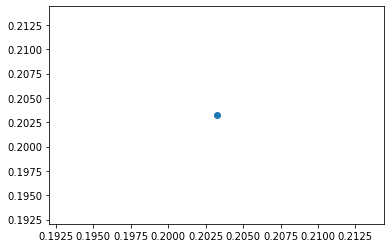

In [8]:
x, y = exhaust_vs_heuristic[:, 0], exhaust_vs_heuristic[:, 1]
plt.scatter(x, y)

107,
136,
152,
187,
245,
268,
331,
345,
365,
368,
401,
431,
445,
465,
Achived perfect alignment on 2/16 samples
4,
19,
33,
39,
46,
50,
62,
92,
96,
97,
187,
206,
210,
221,
223,
233,
239,
292,
304,
319,
333,
339,
346,
350,
362,
392,
396,
397,
433,
446,
492,
Achived perfect alignment on 0/31 samples


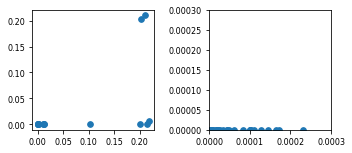

In [9]:
ref_chars = ["5EA6", "6307"]#["5EA6", "6620", "6307", "5247"]
fig, axs = plt.subplots(1, len(ref_chars), figsize=(5.25, 2.625))

f_read = [str(i) for i in range(600)]

plt.rcParams.update({'font.size': 8})

fig.tight_layout(pad=3.0)
for i, ref_char, ax in zip(range(len(ref_chars)), ref_chars, axs.flatten()):
    #ax.set_title(f"{han_char} Transposed to {ref_char}", fontsize=36)
    #ax.set_xlabel(f"Exhaustive Max Score", fontsize=36)
    #ax.set_ylabel(f"Greedy Alignment Score", fontsize=36)
    ax.tick_params(axis='both', which='major', labelsize=8)
    if i == 1:
        ax.set_xlim([0, 0.0003])
        ax.set_ylim([0, 0.0003])
    #ax.set_yscale('log')
    
    exhaust_vs_heuristic, identical_counts = sortExhaustiveScores(ref_char, han_char, f_read)
    if len(exhaust_vs_heuristic) != 0:
        x, y = exhaust_vs_heuristic[:, 0], exhaust_vs_heuristic[:, 1]
        ax.scatter(x, y, s=32)
    print(f"Achived perfect alignment on {identical_counts.sum()}/{identical_counts.shape[0]} samples")
plt.savefig("Figure_Matching.png", bbox_inches='tight', dpi=300)

# Error Estimation Algorithm
Let Ref be the set of edge points in the Archetype stroke and Gene be the sets of edge points in the gene stroke.
$$error_{Ref-Gene} = \sum_{n=1}^{E} \sqrt{|Ref_{n}^2 - Gene_{n}^2|}$$

$n$ represents each edge point on the Reference Stroke

$n\%progress$ is the percent progress at which point n is located on the Reference stroke

$Ref_{n\%progress}$ and $Gene_{n\%progress}$ are the (x, y) vectors at the given percent progress.

In the formula above, the Euclidian distance formula is being applied to both the x and y components.

$P$ is the total number of edge points on the Reference Stroke.

We also calculate the error of the Reference Stroke against the gene stroke as follows:
$$error_{Gene-Ref} = \sum_{n=1}^{E} \sqrt{|Gene_{n}^2 - Ref_{n}^2|}$$
Where n%progress indicates the percent progress for the points on the gene stroke as opposed to the reference

To account for the possibility that the points in the strokes are arranged backwards, we also calculate the error of the strokes with one of the progress percents flipped:
$$error_{Ref-Gene-T} = \sum_{n=1}^{E} \sqrt{|Ref_{n}^2 - Gene_{1-n}^2|}$$
$$error_{Gene-Ref-T} = \sum_{n=1}^{E} \sqrt{|Gene_{n}^2 - Ref_{1-n}^2|}$$

We then evaluate
$$\min{(\max{(error_{Ref-Gene}, error_{Gene-Ref})}, \max{(error_{Ref-Gene-T}, error_{Gene-Ref-T})})}$$
to calculate the final error between the strokes